<a href="https://colab.research.google.com/github/tnwlvos/machinelearning2/blob/main/GAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [113]:
# 필요한 라이브러리 numpy 불러오기
import numpy as np

# 딥러닝용 keras 불러오기
import keras

# 시각화를 위한 matplotlib
import matplotlib.pyplot as plt


# MNIST 데이터셋 로드 (train/test 분리됨)
mnist = keras.datasets.mnist
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# 학습 데이터를 0~255 → 0~1로 변환 후
#x_train = x_train/ 127.5 -1
x_train = x_train.astype("float32") / 255.0

# 0~1 → -1~1 로 스케일링
x_train = x_train * 2.0 - 1.0

# 테스트 데이터를 0~255 → 0~1로 변환
x_test = x_test.astype("float32") / 255.0

# 0~1 → -1~1 로 스케일링
x_test = x_test * 2.0 - 1.0

# step1: Fully-connected 입력 형태 (flatten) — 현재는 사용 안 함
# x_train= x_train.reshape(len(x_train),784)

# step2(CNN용): 채널 차원 추가 → (N,28,28,1) 형태 만들기
x_train = np.expand_dims(x_train, axis=-1)  # (N,28,28,1)

# 테스트 데이터도 동일하게 채널 차원 추가
x_test = np.expand_dims(x_test, axis=-1)


In [114]:
# -----------------------------
# Optimizer — D/G LR 다르게 설정
# -----------------------------
opt_D = keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5)
opt_G = keras.optimizers.Adam(learning_rate=0.0004, beta_1=0.5)   #

In [115]:
# 노이즈 벡터 차원 크기 설정
noise_dimension = 64

# 배치 크기 설정
batch_size = 64

# 총 학습 반복 횟수
iterration = 4000

# 클래스 개수(MNIST는 0~9 → 10개)
num_classes = 10


# step1: Dense 기반 간단한 GAN Generator
# generator = keras.models.Sequential([
#     keras.layers.Dense(256, activation='relu', input_dim=noise_dimension),
#     keras.layers.BatchNormalization(),
#     keras.layers.Dense(512, activation='relu'),
#     keras.layers.BatchNormalization(),
#     keras.layers.Dense(1024, activation='relu'),
#     keras.layers.Dense(28 * 28, activation='tanh'),
# ])

# step2: CNN 기반 DCGAN Generator
# generator = keras.Sequential([
#     keras.layers.Input(shape=(noise_dimension,)),
#     keras.layers.Dense(7 * 7 * 256, use_bias=False),
#     keras.layers.BatchNormalization(),
#     keras.layers.ReLU(),
#     keras.layers.Reshape((7, 7, 256)),

#     keras.layers.Conv2DTranspose(128, (5,5), strides=2, padding='same'),
#     keras.layers.BatchNormalization(),
#     keras.layers.ReLU(),

#     keras.layers.Conv2DTranspose(64, (5,5), strides=2, padding='same'),
#     keras.layers.BatchNormalization(),
#     keras.layers.ReLU(),

#     keras.layers.Conv2DTranspose(1, (5,5), strides=1, padding='same', activation='tanh')
# ])

#step 3:cGAN 기반 Generator
# noise 입력 생성
noise_input = keras.layers.Input(shape=(noise_dimension,))

# class label 입력 생성
label_input = keras.layers.Input(shape=(1,), dtype="int32")

# 레이블을 작은 dimension으로 임베딩
label_embedding = keras.layers.Embedding(num_classes, 32)(label_input)
label_embedding = keras.layers.Flatten()(label_embedding)

# 노이즈 벡터와 label embedding 결합
merged = keras.layers.Concatenate()([noise_input, label_embedding])

# Dense Projection (7×7×256 크기 특징맵 초기 생성)
x = keras.layers.Dense(7 * 7 * 256, use_bias=False)(merged)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.LeakyReLU(0.2)(x)

# (7, 7, 256) 형태로 reshape
x = keras.layers.Reshape((7, 7, 256))(x)

# 업샘플링 1단계 (7→14)
x = keras.layers.Conv2DTranspose(128, kernel_size=5, strides=2, padding='same', use_bias=False)(x)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.LeakyReLU(0.2)(x)

# 업샘플링 2단계 (14→28)
x = keras.layers.Conv2DTranspose(64, kernel_size=5, strides=2, padding='same', use_bias=False)(x)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.LeakyReLU(0.2)(x)

# 최종 출력층 (28×28×1 이미지 생성 / -1~1 범위)
out_img = keras.layers.Conv2DTranspose(
    1, kernel_size=5, strides=1, padding='same', activation='tanh'
)(x)

# Generator 모델 구성
generator = keras.Model([noise_input, label_input], out_img)

# 모델 구조 출력
generator.summary()


Model: "functional_40"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_71      │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_18        │ (None, 1, 32)     │        320 │ input_layer_71[0… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_70      │ (None, 64)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_31          │ (None, 32)        │          0 │ embedding_18[0][… │
│ (Flatten)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_18      │ (None, 96)        │          0 │ input_layer_70[0… │
│ (Concatenate)       │                   │            │ flatten_31[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_29 (Dense)    │ (None, 12544)     │  1,204,224 │ concatenate_18[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 12544)     │     50,176 │ dense_29[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_34      │ (None, 12544)     │          0 │ batch_normalizat… │
│ (LeakyReLU)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_22          │ (None, 7, 7, 256) │          0 │ leaky_re_lu_34[0… │
│ (Reshape)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_transpose_42 │ (None, 14, 14,    │    819,200 │ reshape_22[0][0]  │
│ (Conv2DTranspose)   │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 14, 14,    │        512 │ conv2d_transpose… │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_35      │ (None, 14, 14,    │          0 │ batch_normalizat… │
│ (LeakyReLU)         │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_transpose_43 │ (None, 28, 28,    │    204,800 │ leaky_re_lu_35[0… │
│ (Conv2DTranspose)   │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 28, 28,    │        256 │ conv2d_transpose… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_36      │ (None, 28, 28,    │          0 │ batch_normalizat… │
│ (LeakyReLU)         │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_transpose_44 │ (None, 28, 28, 1) │      1,601 │ leaky_re_lu_36[0… │
│ (Conv2DTranspose)   │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 2,281,089 (8.70 MB)

 Trainable params: 2,255,617 (8.60 MB)

 Non-trainable params: 25,472 (99.50 KB)

In [116]:
# step1: Dense 기반 Discriminator
# discriminator = keras.models.Sequential([
#     keras.layers.Dense(1024, activation='relu', input_shape=(784,)),
#     keras.layers.Dropout(0.3),
#     keras.layers.Dense(512, activation='relu'),
#     keras.layers.Dropout(0.3),
#     keras.layers.Dense(256, activation='relu'),
#     keras.layers.Dropout(0.3),
#     keras.layers.Dense(1, activation='sigmoid'),
# ])

# step2: CNN 기반 Discriminator
# discriminator = keras.Sequential([
#     keras.layers.Input(shape=(28, 28, 1)),
#     keras.layers.Conv2D(64, (5, 5), strides=2, padding='same'),
#     keras.layers.LeakyReLU(0.2),
#     keras.layers.Dropout(0.3),
#     keras.layers.Conv2D(128, (5, 5), strides=2, padding='same'),
#     keras.layers.LeakyReLU(0.2),
#     keras.layers.Dropout(0.3),
#     keras.layers.Flatten(),
#     keras.layers.Dense(1, activation='sigmoid')
# ])

#step 3:cGAN 기반 Discriminator
# 입력 이미지 텐서 정의
img_input = keras.layers.Input(shape=(28, 28, 1))

# 라벨 입력 텐서 정의
label_input = keras.layers.Input(shape=(1,), dtype="int32")

# 라벨을 Embedding하여 특징 벡터 생성
label_embedding = keras.layers.Embedding(num_classes, 32)(label_input)

# 임베딩을 이미지 크기에 맞게 Dense projection으로 확대
label_embedding = keras.layers.Dense(28 * 28)(label_embedding)

# 2D 이미지 형태로 reshape
label_embedding = keras.layers.Reshape((28, 28, 1))(label_embedding)

# 원본 이미지와 라벨 이미지를 채널 기준으로 결합
merged = keras.layers.Concatenate(axis=-1)([img_input, label_embedding])

# 첫 번째 Convolution (Downsampling: 28→14)
x = keras.layers.Conv2D(64, kernel_size=5, strides=2, padding='same')(merged)
x = keras.layers.LeakyReLU(0.2)(x)
x = keras.layers.Dropout(0.3)(x)

# 두 번째 Convolution (Downsampling: 14→7)
x = keras.layers.Conv2D(128, kernel_size=5, strides=2, padding='same')(x)
x = keras.layers.LeakyReLU(0.2)(x)
x = keras.layers.Dropout(0.3)(x)

# 특징 맵을 1D로 펼치기
x = keras.layers.Flatten()(x)

# 최종 진짜/가짜 판별 출력층
out = keras.layers.Dense(1, activation='sigmoid')(x)

# Discriminator 모델 구성
discriminator = keras.Model([img_input, label_input], out)

# 모델 요약 출력
discriminator.summary()


Model: "functional_41"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_73      │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_19        │ (None, 1, 32)     │        320 │ input_layer_73[0… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_30 (Dense)    │ (None, 1, 784)    │     25,872 │ embedding_19[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_72      │ (None, 28, 28, 1) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_23          │ (None, 28, 28, 1) │          0 │ dense_30[0][0]    │
│ (Reshape)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_19      │ (None, 28, 28, 2) │          0 │ input_layer_72[0… │
│ (Concatenate)       │                   │            │ reshape_23[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_28 (Conv2D)  │ (None, 14, 14,    │      3,264 │ concatenate_19[0… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_37      │ (None, 14, 14,    │          0 │ conv2d_28[0][0]   │
│ (LeakyReLU)         │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_28          │ (None, 14, 14,    │          0 │ leaky_re_lu_37[0… │
│ (Dropout)           │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_29 (Conv2D)  │ (None, 7, 7, 128) │    204,928 │ dropout_28[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_38      │ (None, 7, 7, 128) │          0 │ conv2d_29[0][0]   │
│ (LeakyReLU)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_29          │ (None, 7, 7, 128) │          0 │ leaky_re_lu_38[0… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_32          │ (None, 6272)      │          0 │ dropout_29[0][0]  │
│ (Flatten)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_31 (Dense)    │ (None, 1)         │      6,273 │ flatten_32[0][0]  │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 240,657 (940.07 KB)

 Trainable params: 240,657 (940.07 KB)

 Non-trainable params: 0 (0.00 B)

In [117]:
# Discriminator를 먼저 binary crossentropy + opt_D 로 컴파일
discriminator.compile(loss='binary_crossentropy', optimizer=opt_D)

# GAN 학습 시 Discriminator의 가중치를 업데이트하지 않도록 고정
discriminator.trainable = False


# step2
# gan_input = keras.layers.Input(shape=(noise_dimension,))
# fake_image = generator(gan_input)
# gan_output = discriminator(fake_image)
# gan = keras.Model(gan_input, gan_output)
# gan.compile(loss='binary_crossentropy', optimizer=opt_G)

#step3
# 노이즈 입력 정의
noise_input = keras.layers.Input(shape=(noise_dimension,))

# 레이블 입력 정의
label_input = keras.layers.Input(shape=(1,), dtype="int32")

# Noise + Label을 기반으로 Generator가 생성한 이미지
gen_img = generator([noise_input, label_input])

# Generator가 만든 이미지와 같은 Label을 Discriminator에 전달
gan_output = discriminator([gen_img, label_input])

# Generator + Discriminator를 연결한 전체 cGAN 모델 생성
gan = keras.Model([noise_input, label_input], gan_output)

# 최종 GAN을 binary crossentropy + opt_G 로 컴파일
gan.compile(loss='binary_crossentropy', optimizer=opt_G)


In [118]:
# -----------------------------
# STEP 1 — 안정화 기능들
# -----------------------------

# 1) Label smoothing
# def smooth_labels(labels):
#     return labels * 0.9  # 진짜=0.9 로 만들기

def smooth_labels(labels, smoothing=0.1):
    """real=1.0 대신 1-smoothing 근처로 만들어줌"""
    return labels - smoothing * np.random.rand(*labels.shape)
# 2) Label flipping
def random_flip(labels, flip_rate=0.05):
    flip_idx = np.random.rand(labels.shape[0]) < flip_rate
    labels[flip_idx] = 1 - labels[flip_idx]
    return labels

# 3) Noisy labels
def add_noise(labels, noise_range=0.02):
    noise = np.random.uniform(-noise_range, noise_range, labels.shape)
    labels = labels + noise
    return np.clip(labels, 0, 1)   # 0~1 사이로 클립

In [119]:

#step1~2
# Discriminator 학습 함수 정의
def train_discriminator(x_train):
    # Discriminator 파라미터 업데이트 허용
    discriminator.trainable = True

    # 실데이터 배치 랜덤 선택
    c = np.random.randint(0, x_train.shape[0], batch_size)
    real = x_train[c]

    # 실데이터 라벨 = 1
    real_labels = np.ones((batch_size, 1))

    # Label smoothing 적용
    real_labels = smooth_labels(real_labels)

    # 노이즈 추가
    real_labels = add_noise(real_labels)

    # Label flipping 적용
    real_labels = random_flip(real_labels)

    # 실데이터에 대한 Discriminator 손실 계산
    d_loss_real = discriminator.train_on_batch(real, real_labels)

    # GAN 노이즈 생성
    p = np.random.normal(0, 1, (batch_size, noise_dimension))

    # Generator가 만든 fake 이미지 생성
    fake = generator.predict(p)

    # 가짜 라벨 = 0
    fake_labels = np.zeros((batch_size, 1))

    # 노이즈 추가
    fake_labels = add_noise(fake_labels)

    # Label flipping 적용
    fake_labels = random_flip(fake_labels)

    # 가짜 데이터에 대한 Discriminator 손실 계산
    d_loss_fake = discriminator.train_on_batch(fake, fake_labels)

    # Discriminator가 실데이터를 얼마나 진짜로 보는지 확인
    real_pred = discriminator.predict(real[:5])

    # Discriminator가 가짜데이터를 얼마나 진짜로 착각하는지 확인
    fake_pred = discriminator.predict(fake[:5])

    # 총 loss, 실데이터 평균 출력값, 가짜데이터 평균 출력값 반환
    return d_loss_real + d_loss_fake, real_pred.mean(), fake_pred.mean()


# Generator 학습 함수 정의
def train_generator():
    # Generator 학습 시 Discriminator 파라미터 고정
    discriminator.trainable = False

    # 랜덤 노이즈 배치 생성
    p = np.random.normal(0, 1, (batch_size, noise_dimension))

    # Generator가 원하는 라벨 = 1 (진짜처럼 보이도록)
    target_labels = np.ones((batch_size, 1))

    # Label smoothing 적용
    target_labels = smooth_labels(target_labels)

    # GAN 전체 모델 학습(Generator 업데이트)
    g_loss = gan.train_on_batch(p, target_labels)

    # Generator loss 반환
    return g_loss


In [120]:
#step3
# Discriminator 학습 (실제 이미지 + 레이블 / 가짜 이미지 + 레이블)
def train_discriminator_step3(x_train, y_train):
    # Discriminator 업데이트 허용
    discriminator.trainable = True

    # ----- Real -----
    # 배치 크기만큼 랜덤 인덱스 선택
    idx = np.random.randint(0, x_train.shape[0], batch_size)

    # 실 이미지 선택
    real_imgs = x_train[idx]

    # 해당 이미지의 레이블 가져오기
    real_labels = y_train[idx].reshape(-1, 1).astype("int32")

    # 실 데이터 타겟 = 1
    valid = np.ones((batch_size, 1), dtype="float32")

    # label smoothing 적용
    valid = smooth_labels(valid, smoothing=0.1)

    # small noise 추가
    valid = add_noise(valid, noise_range=0.02)

    # 실데이터로 D 학습
    d_loss_real = discriminator.train_on_batch(
        [real_imgs, real_labels], valid
    )

    # ----- Fake -----
    # 노이즈 생성
    noise = np.random.normal(0, 1, (batch_size, noise_dimension))

    # 랜덤한 클래스 레이블 샘플링
    sampled_labels = np.random.randint(
        0, num_classes, (batch_size, 1)
    ).astype("int32")

    # G로부터 가짜 이미지 생성
    fake_imgs = generator.predict(
        [noise, sampled_labels], verbose=0
    )

    # 가짜 데이터 타겟 = 0
    fake = np.zeros((batch_size, 1), dtype="float32")

    # small noise 추가
    fake = add_noise(fake, noise_range=0.02)

    # 가짜데이터로 D 학습
    d_loss_fake = discriminator.train_on_batch(
        [fake_imgs, sampled_labels], fake
    )

    # 실데이터에 대한 D 확신도 계산
    real_prob = discriminator.predict(
        [real_imgs[:8], real_labels[:8]], verbose=0
    ).mean()

    # 가짜데이터에 대한 D 확신도 계산
    fake_prob = discriminator.predict(
        [fake_imgs[:8], sampled_labels[:8]], verbose=0
    ).mean()

    # 총 D loss, 실/가짜 확신도 반환
    return d_loss_real + d_loss_fake, real_prob, fake_prob



# Generator 학습 (G가 D를 속이도록 학습)
def train_generator_step3():
    # Generator 업데이트 시 D 고정
    discriminator.trainable = False

    # 노이즈 배치 생성
    noise = np.random.normal(0, 1, (batch_size, noise_dimension))

    # 랜덤한 클래스 레이블 선택
    sampled_labels = np.random.randint(
        0, num_classes, (batch_size, 1)
    ).astype("int32")

    # 타겟 = 1 (진짜처럼 보이도록)
    target = np.ones((batch_size, 1), dtype="float32")

    # label smoothing 적용
    target = smooth_labels(target, smoothing=0.1)

    # GAN 전체 모델로 G 업데이트
    g_loss = gan.train_on_batch([noise, sampled_labels], target)

    # Generator loss 반환
    return g_loss


00000 | D loss: 1.4284 | G loss: 0.7241 | D(real): 0.562 | D(fake): 0.500


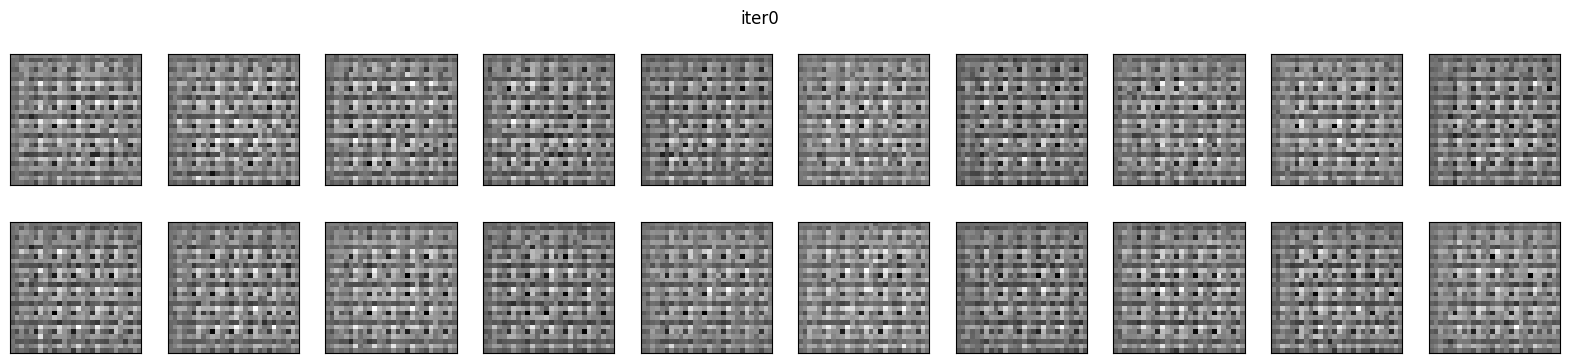

00100 | D loss: 0.6253 | G loss: 0.6765 | D(real): 0.968 | D(fake): 0.019


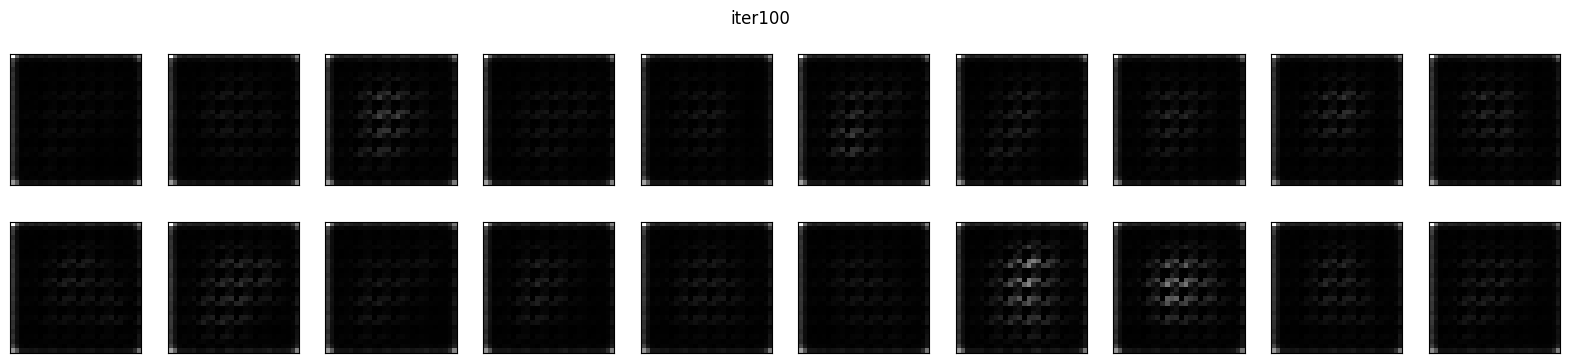

00200 | D loss: 0.4520 | G loss: 0.4408 | D(real): 0.921 | D(fake): 0.011


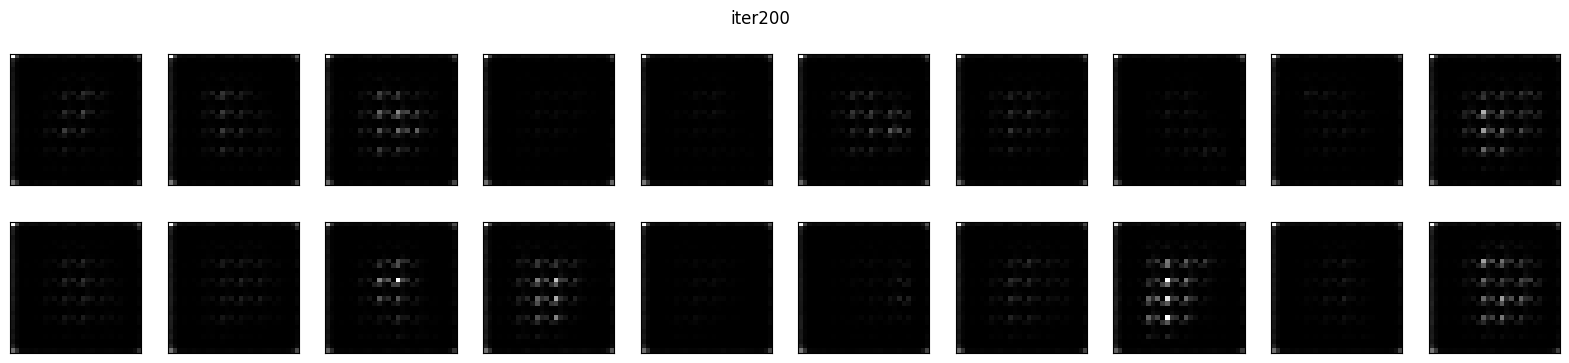

00300 | D loss: 0.3872 | G loss: 0.3607 | D(real): 0.966 | D(fake): 0.009


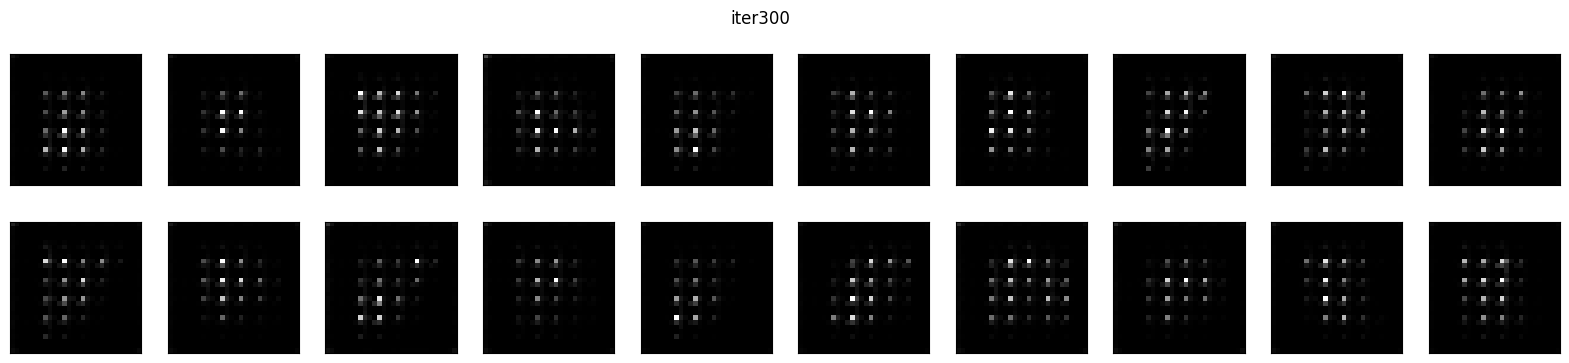

00400 | D loss: 0.3631 | G loss: 0.3553 | D(real): 0.944 | D(fake): 0.010


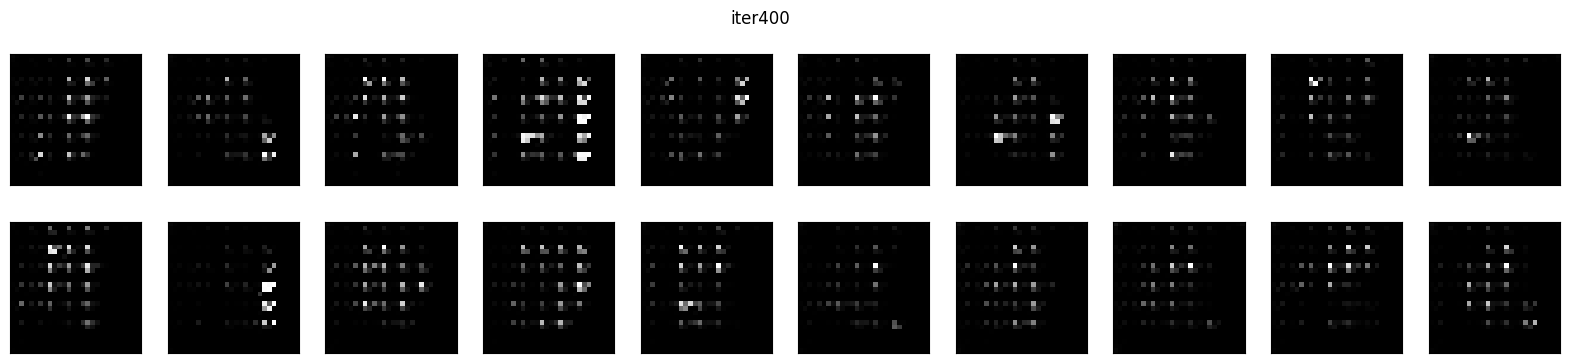

00500 | D loss: 0.5687 | G loss: 0.5023 | D(real): 0.506 | D(fake): 0.466


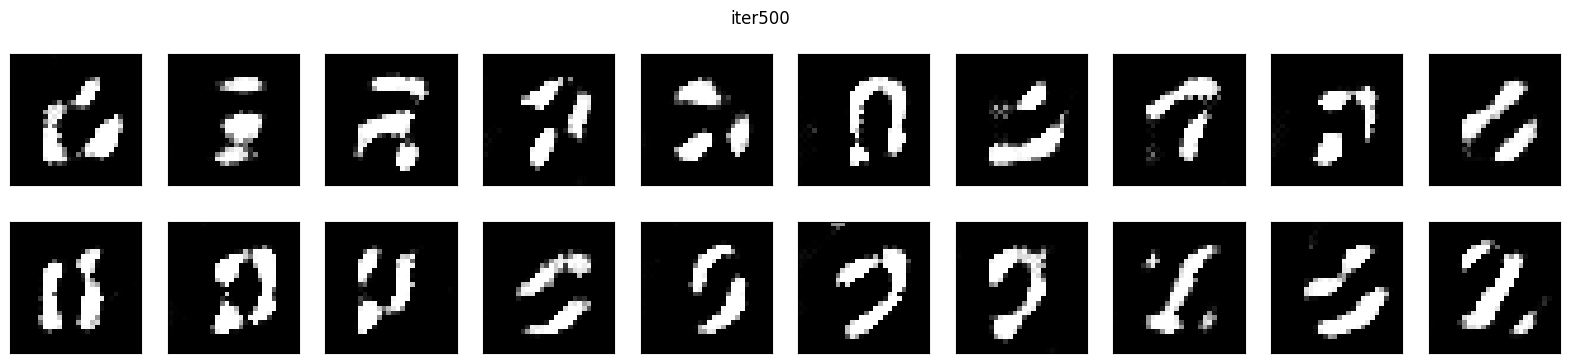

00600 | D loss: 0.7115 | G loss: 0.5435 | D(real): 0.508 | D(fake): 0.477


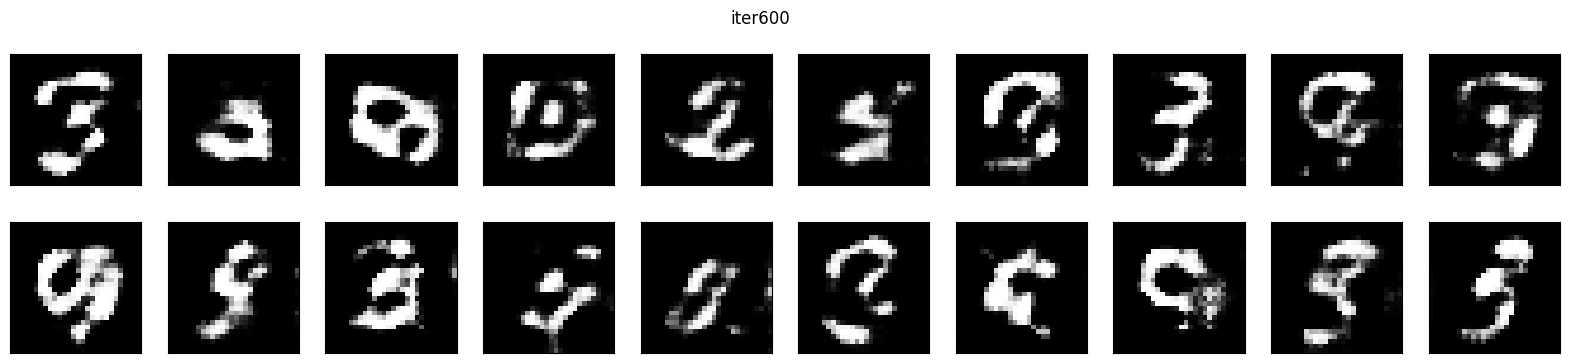

00700 | D loss: 0.8107 | G loss: 0.5709 | D(real): 0.486 | D(fake): 0.478


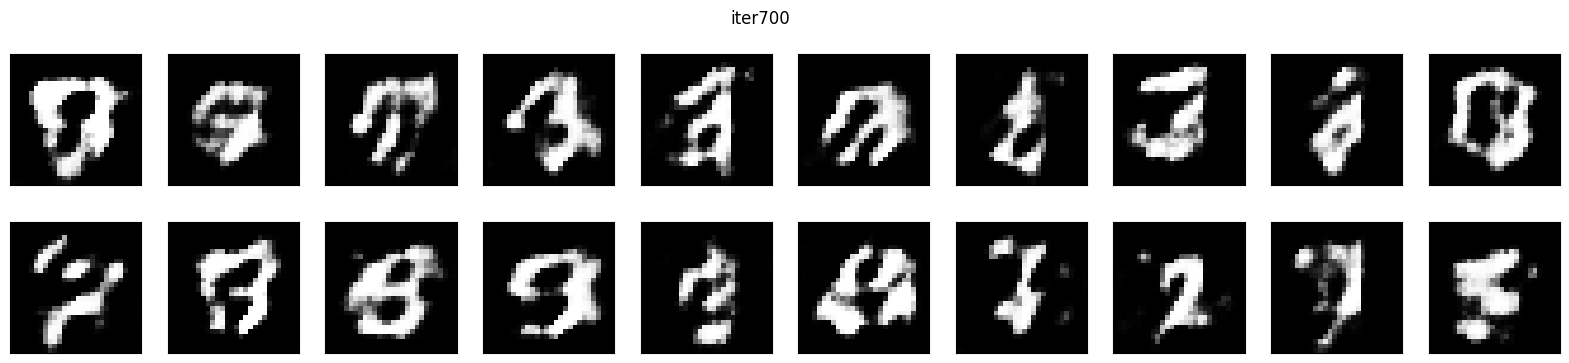

00800 | D loss: 0.8834 | G loss: 0.5924 | D(real): 0.481 | D(fake): 0.462


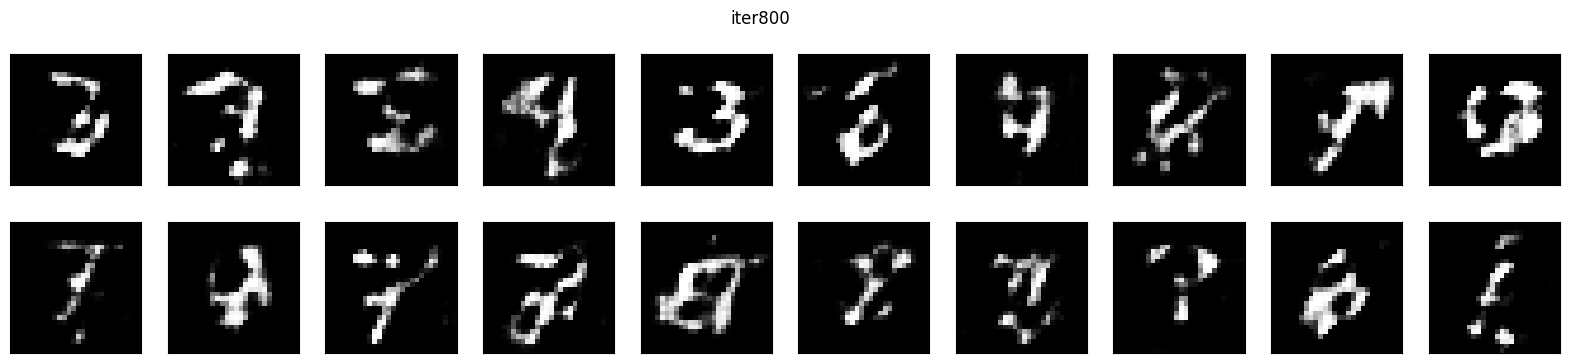

00900 | D loss: 0.9388 | G loss: 0.6097 | D(real): 0.480 | D(fake): 0.473


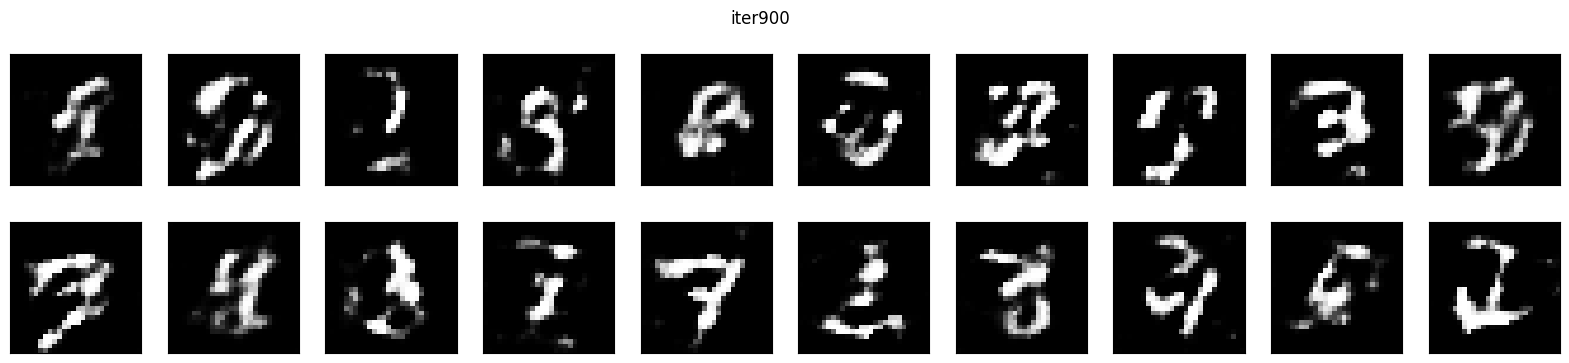

01000 | D loss: 0.9831 | G loss: 0.6241 | D(real): 0.483 | D(fake): 0.459


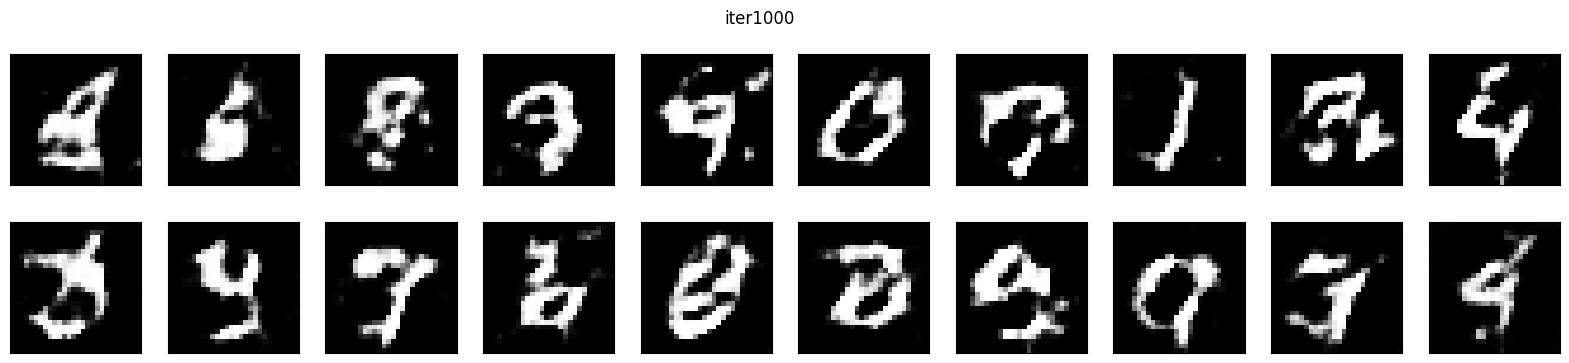

01100 | D loss: 1.0187 | G loss: 0.6363 | D(real): 0.497 | D(fake): 0.452


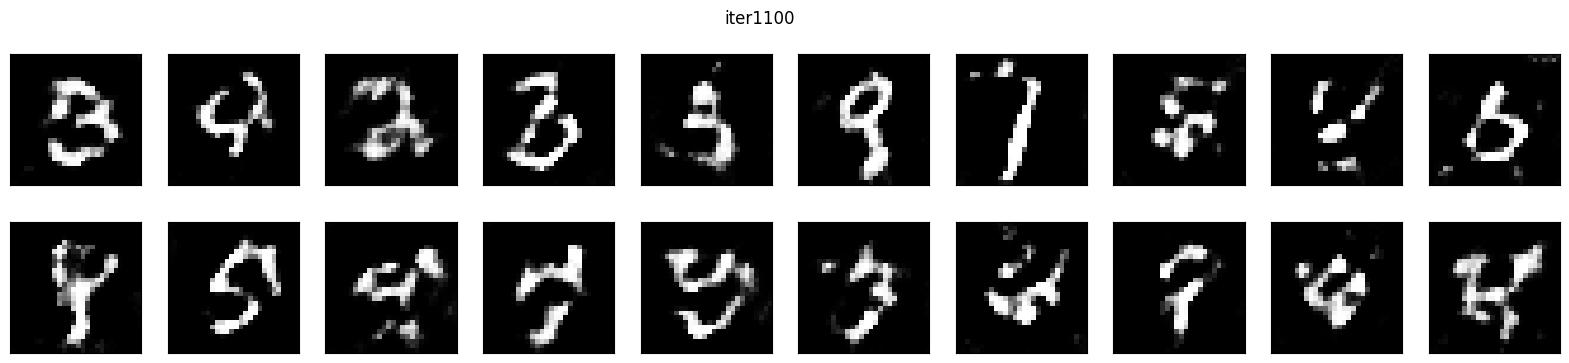

01200 | D loss: 1.0479 | G loss: 0.6465 | D(real): 0.497 | D(fake): 0.468


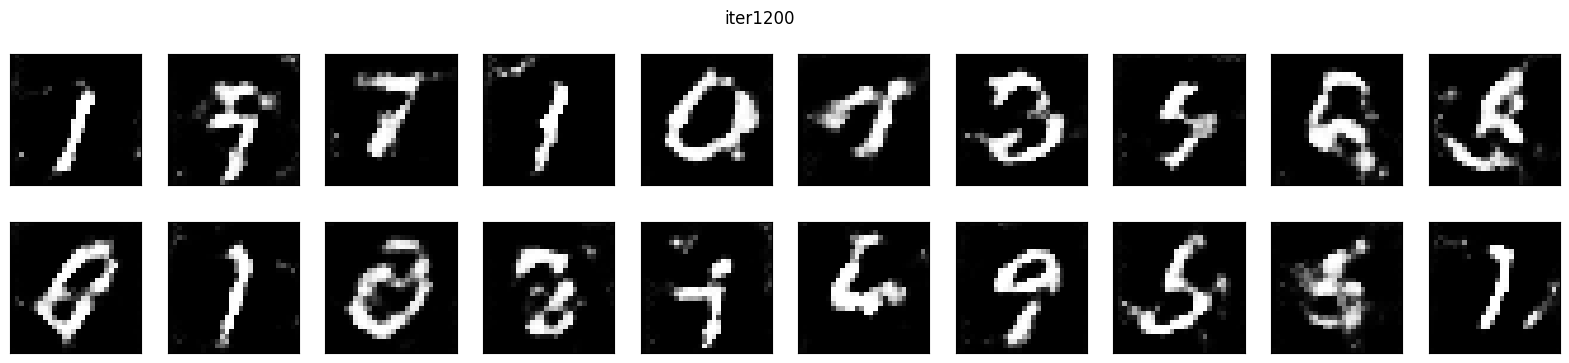

01300 | D loss: 1.0734 | G loss: 0.6548 | D(real): 0.488 | D(fake): 0.466


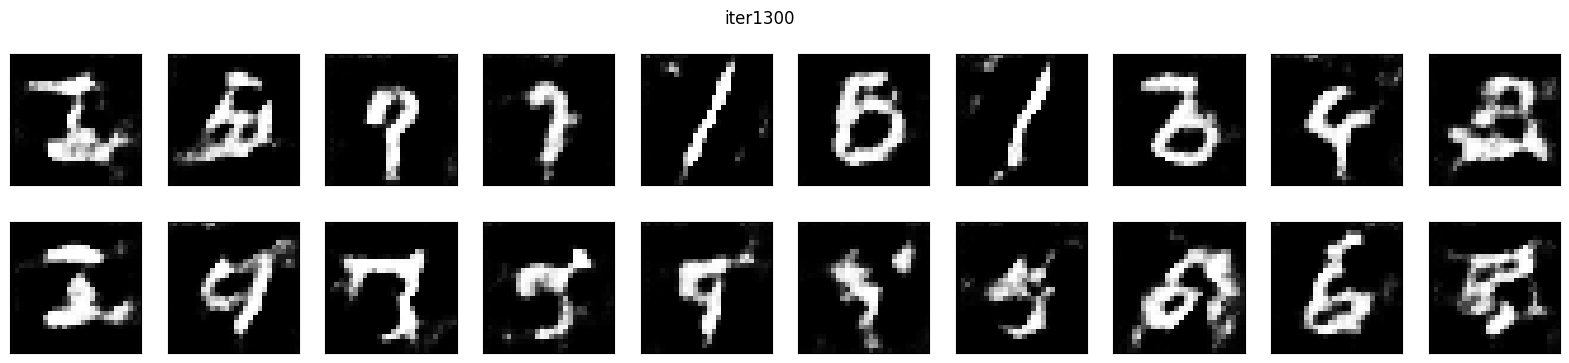

01400 | D loss: 1.0954 | G loss: 0.6619 | D(real): 0.490 | D(fake): 0.467


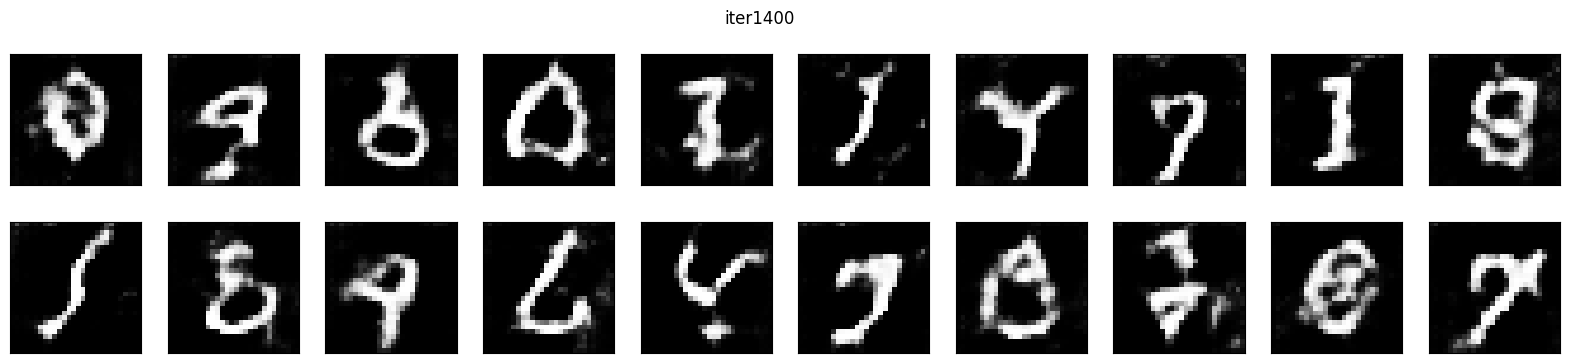

01500 | D loss: 1.1147 | G loss: 0.6678 | D(real): 0.499 | D(fake): 0.460


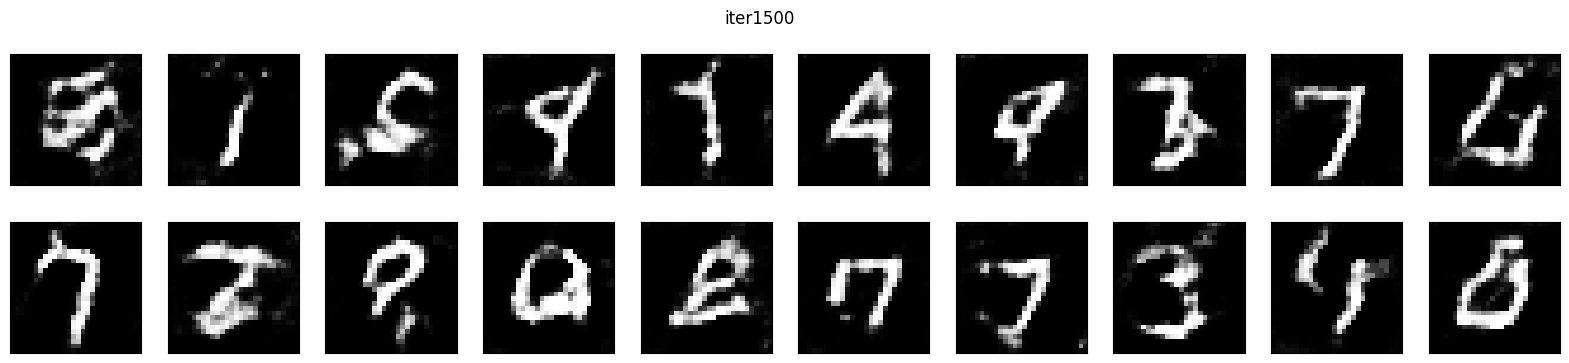

01600 | D loss: 1.1316 | G loss: 0.6731 | D(real): 0.492 | D(fake): 0.471


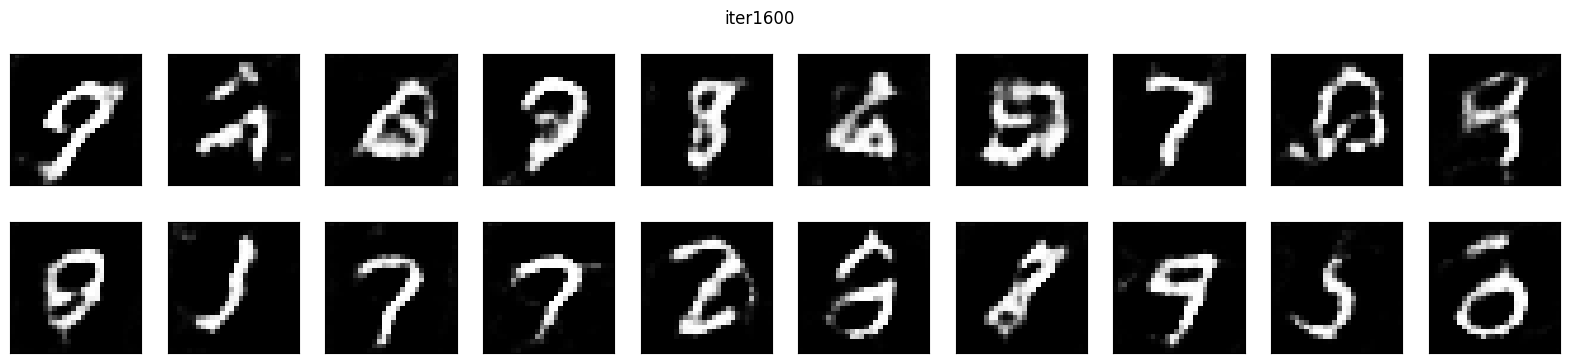

01700 | D loss: 1.1464 | G loss: 0.6778 | D(real): 0.489 | D(fake): 0.478


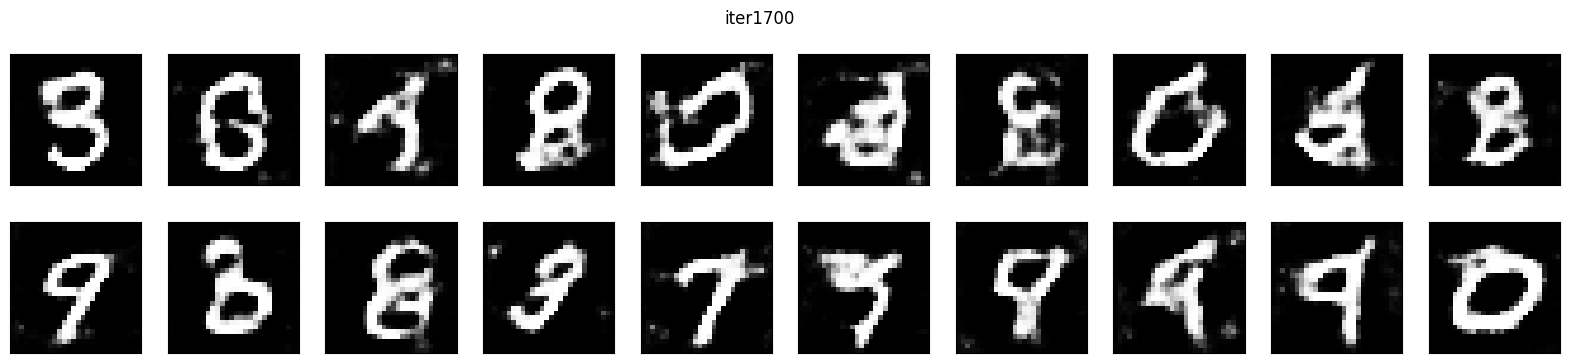

01800 | D loss: 1.1595 | G loss: 0.6821 | D(real): 0.486 | D(fake): 0.475


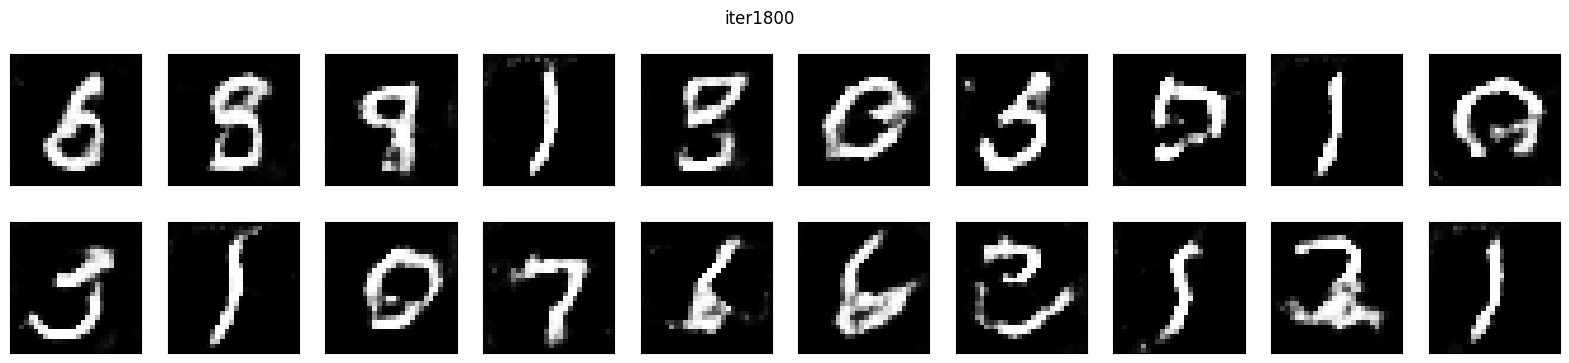

01900 | D loss: 1.1715 | G loss: 0.6856 | D(real): 0.478 | D(fake): 0.458


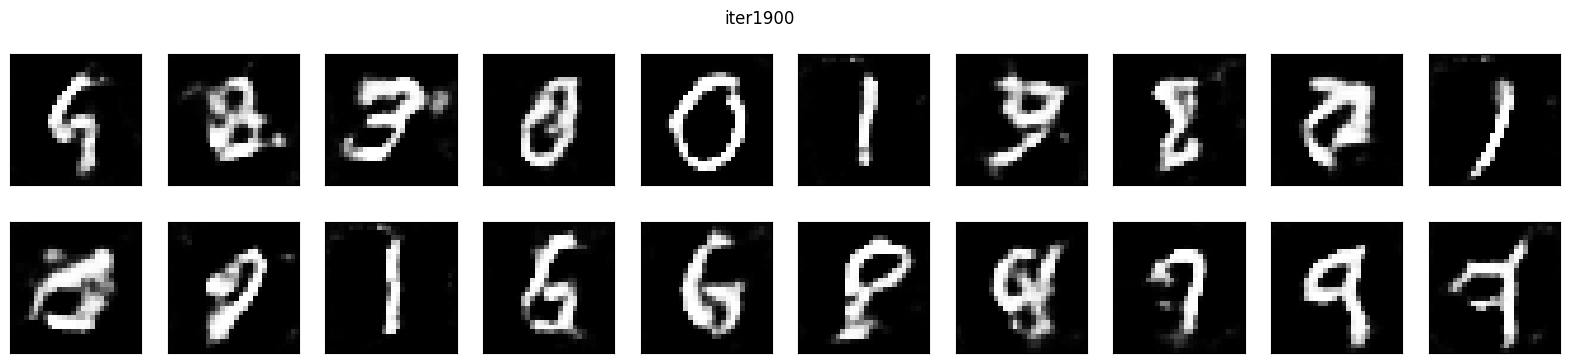

02000 | D loss: 1.1825 | G loss: 0.6887 | D(real): 0.477 | D(fake): 0.474


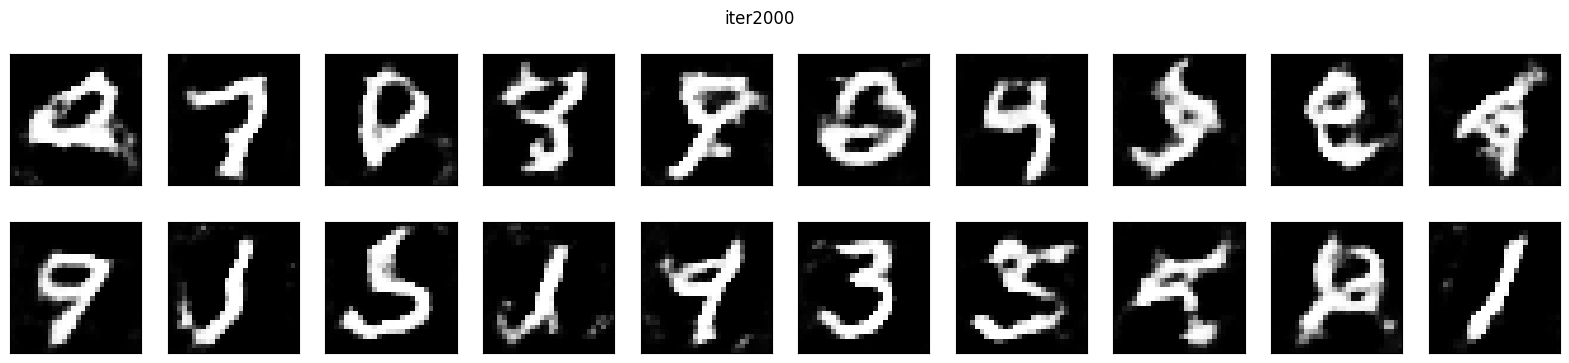

02100 | D loss: 1.1922 | G loss: 0.6915 | D(real): 0.495 | D(fake): 0.468


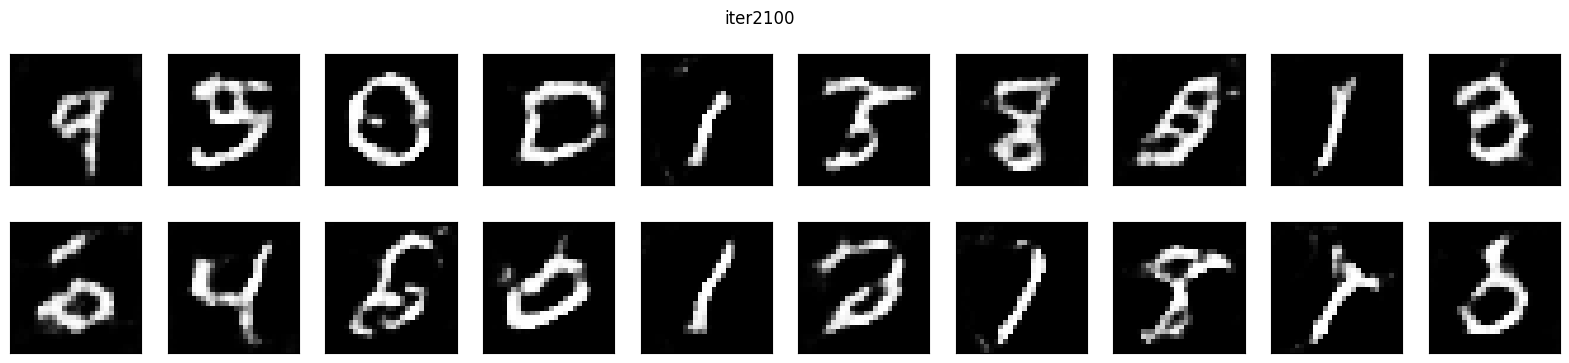

02200 | D loss: 1.2012 | G loss: 0.6940 | D(real): 0.485 | D(fake): 0.476


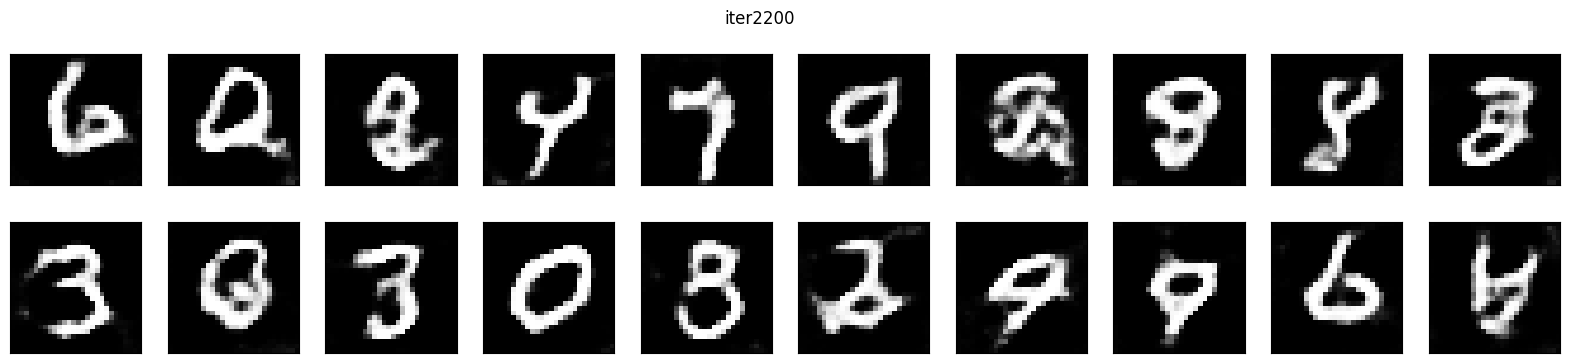

02300 | D loss: 1.2094 | G loss: 0.6963 | D(real): 0.496 | D(fake): 0.489


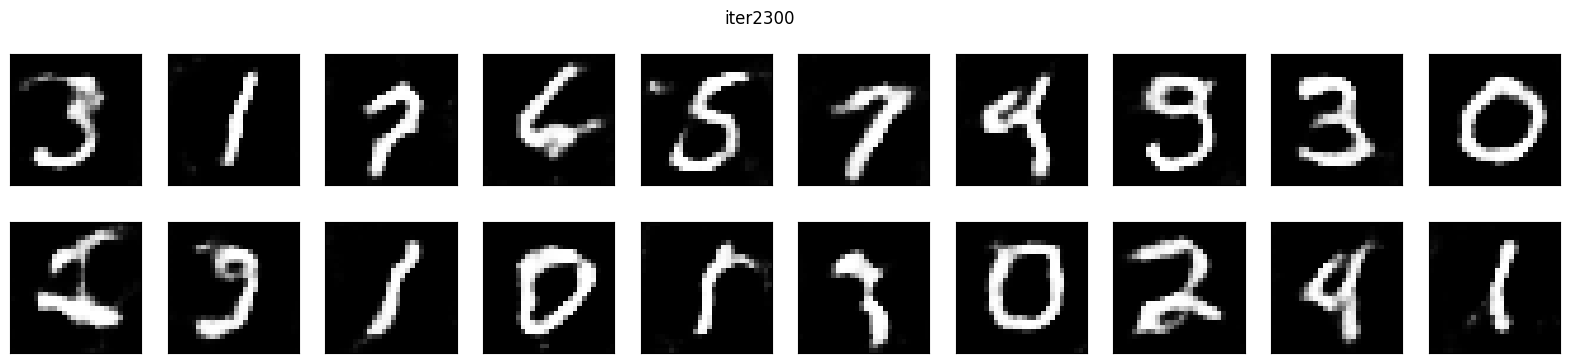

02400 | D loss: 1.2168 | G loss: 0.6984 | D(real): 0.480 | D(fake): 0.473


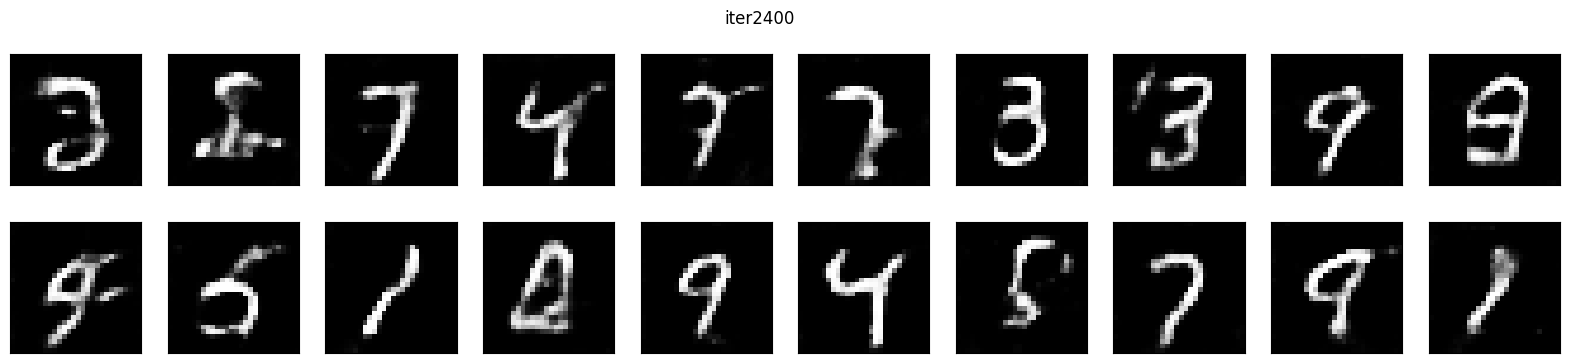

02500 | D loss: 1.2236 | G loss: 0.7003 | D(real): 0.503 | D(fake): 0.474


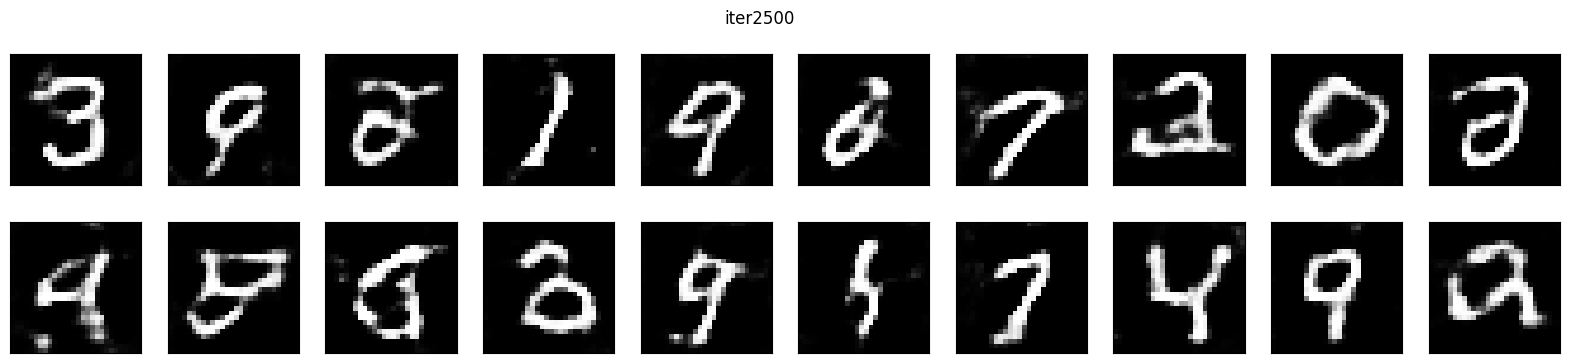

02600 | D loss: 1.2299 | G loss: 0.7020 | D(real): 0.492 | D(fake): 0.473


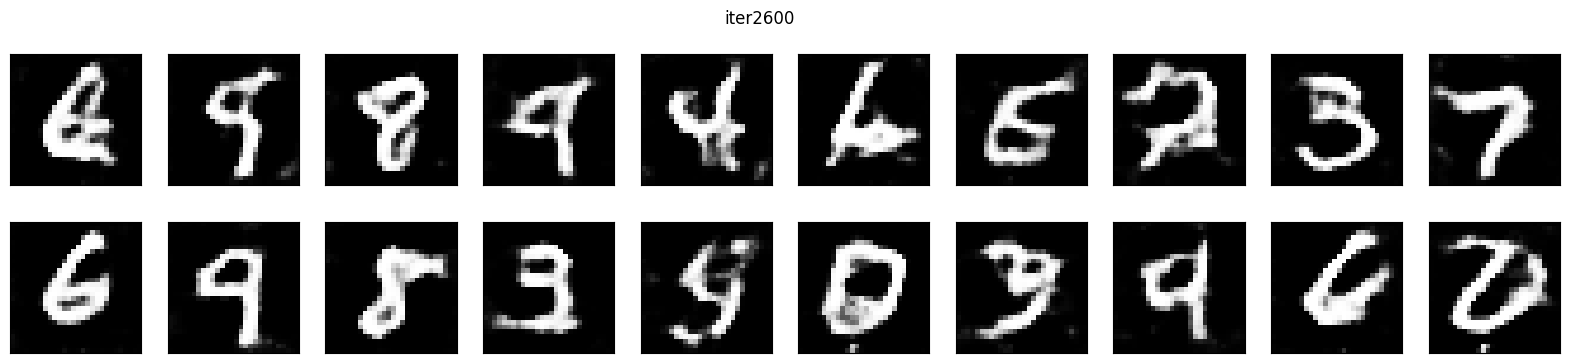

02700 | D loss: 1.2358 | G loss: 0.7036 | D(real): 0.489 | D(fake): 0.463


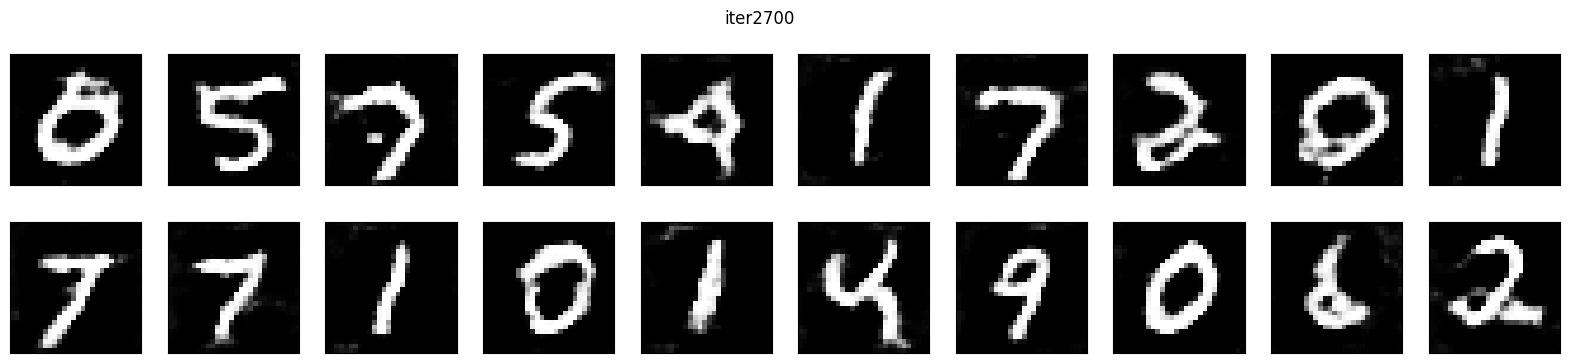

02800 | D loss: 1.2413 | G loss: 0.7052 | D(real): 0.484 | D(fake): 0.475


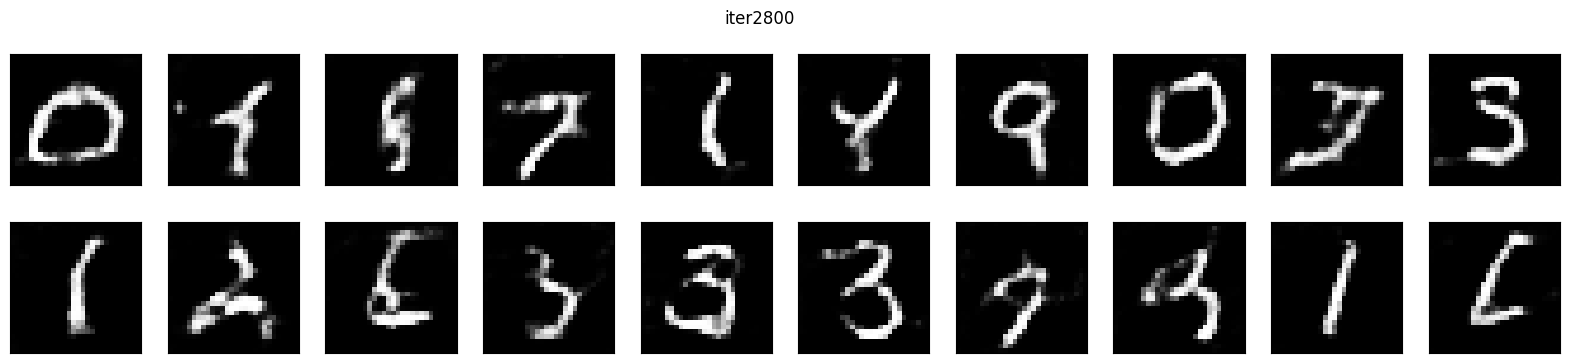

02900 | D loss: 1.2463 | G loss: 0.7064 | D(real): 0.485 | D(fake): 0.493


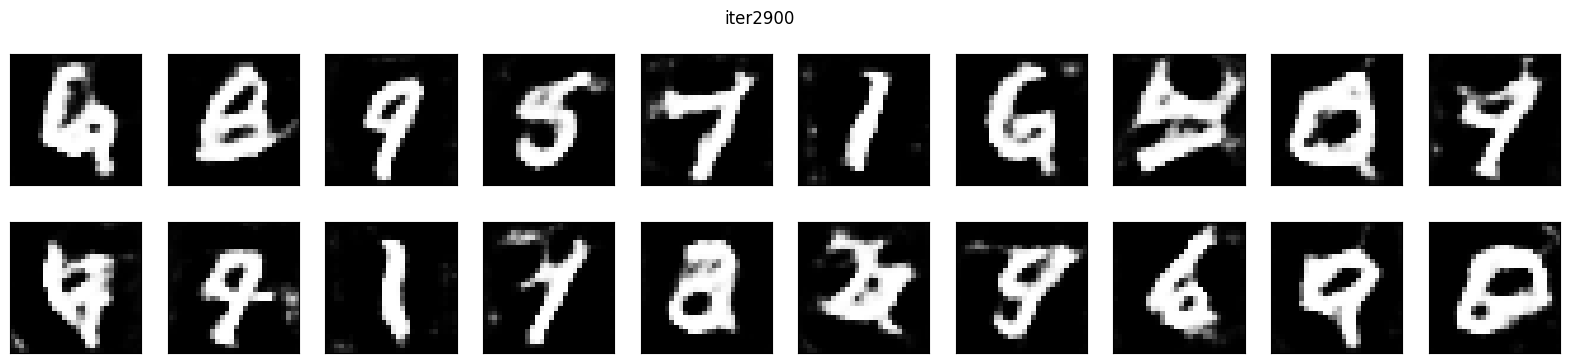

03000 | D loss: 1.2509 | G loss: 0.7078 | D(real): 0.490 | D(fake): 0.480


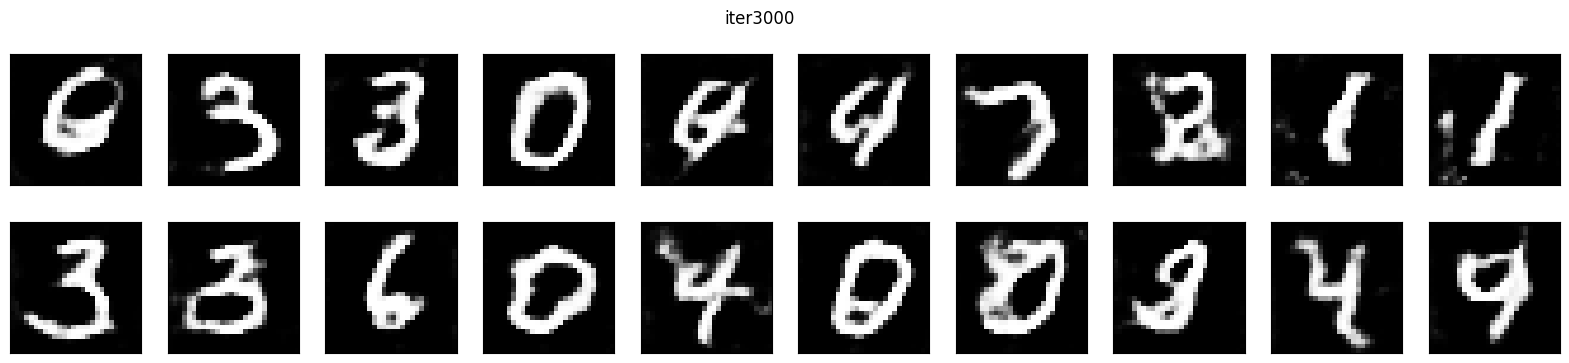

03100 | D loss: 1.2553 | G loss: 0.7090 | D(real): 0.493 | D(fake): 0.480


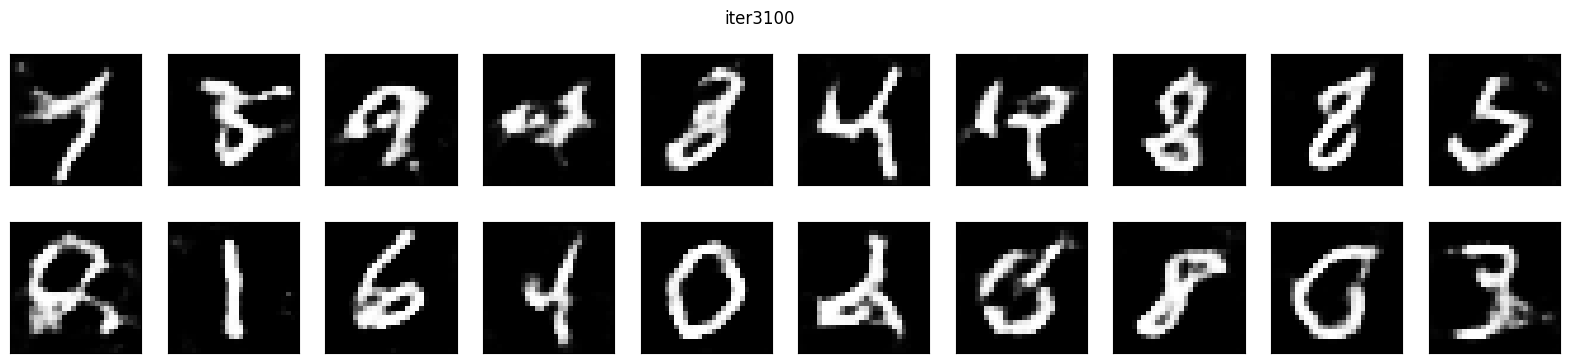

03200 | D loss: 1.2594 | G loss: 0.7101 | D(real): 0.493 | D(fake): 0.497


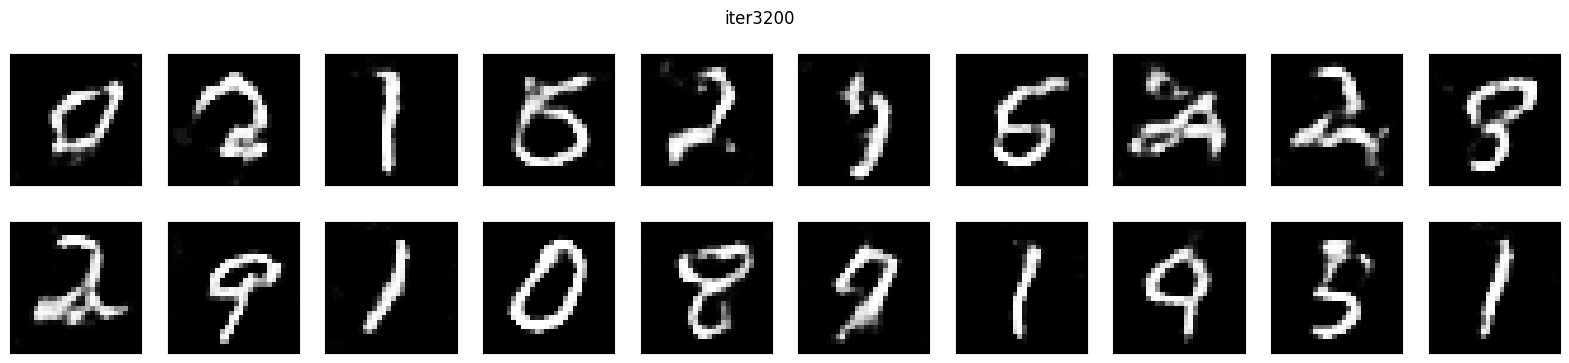

03300 | D loss: 1.2633 | G loss: 0.7112 | D(real): 0.496 | D(fake): 0.468


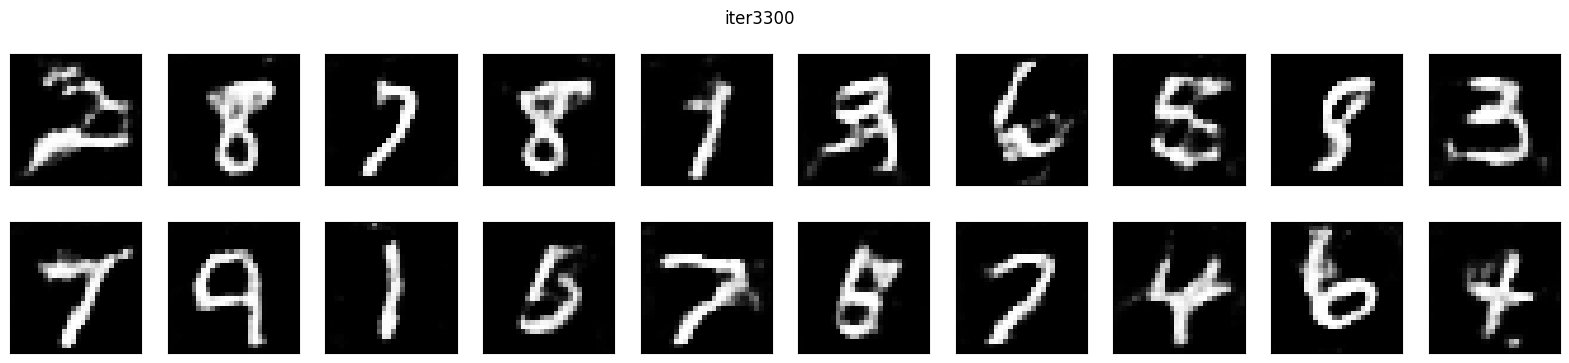

03400 | D loss: 1.2669 | G loss: 0.7122 | D(real): 0.483 | D(fake): 0.489


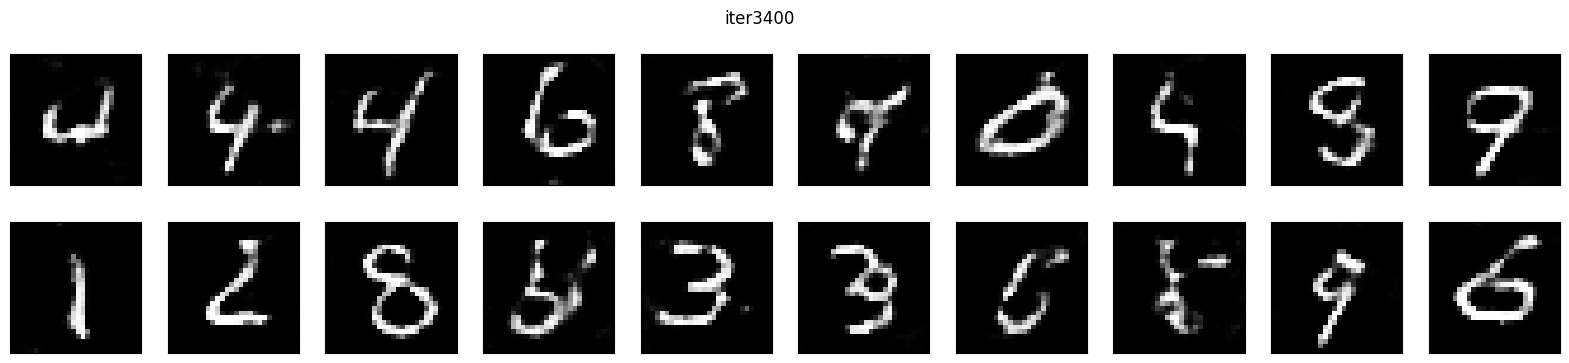

03500 | D loss: 1.2702 | G loss: 0.7132 | D(real): 0.479 | D(fake): 0.483


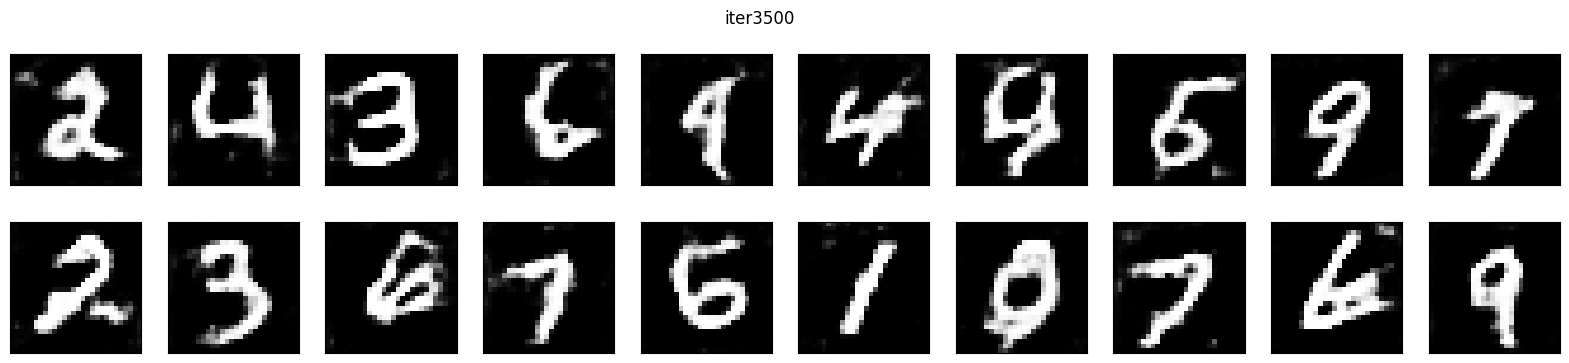

03600 | D loss: 1.2734 | G loss: 0.7142 | D(real): 0.455 | D(fake): 0.481


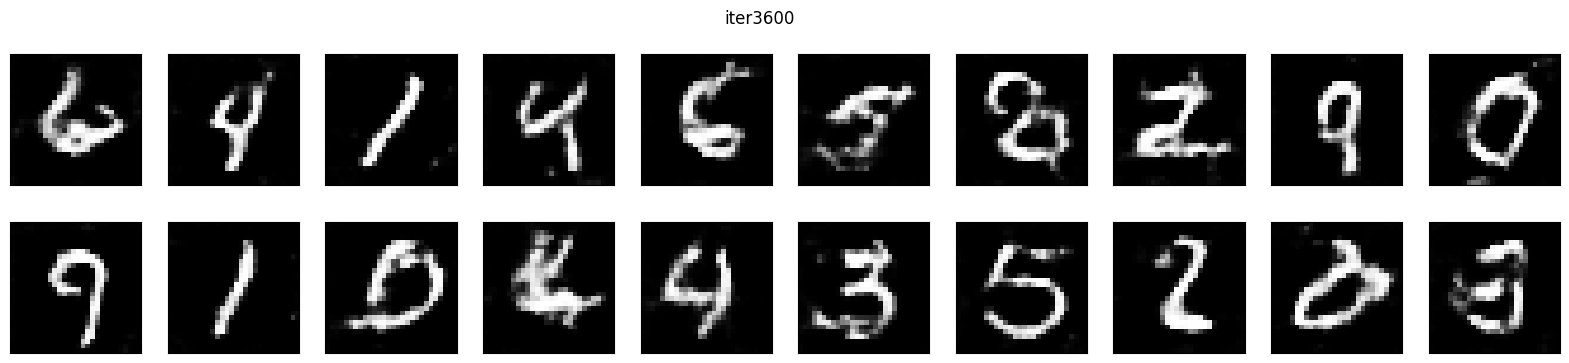

03700 | D loss: 1.2764 | G loss: 0.7151 | D(real): 0.489 | D(fake): 0.482


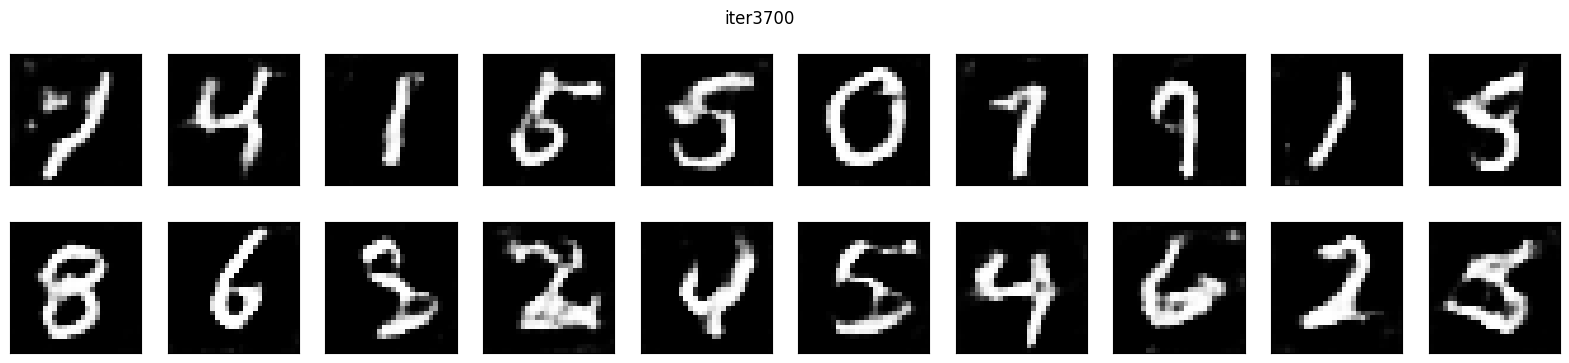

03800 | D loss: 1.2793 | G loss: 0.7158 | D(real): 0.494 | D(fake): 0.469


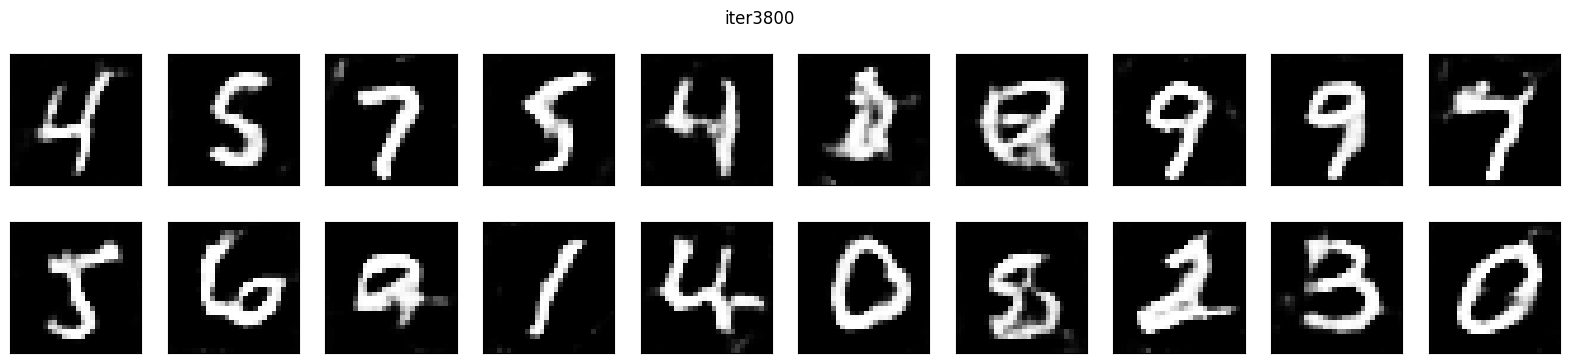

03900 | D loss: 1.2819 | G loss: 0.7167 | D(real): 0.486 | D(fake): 0.458


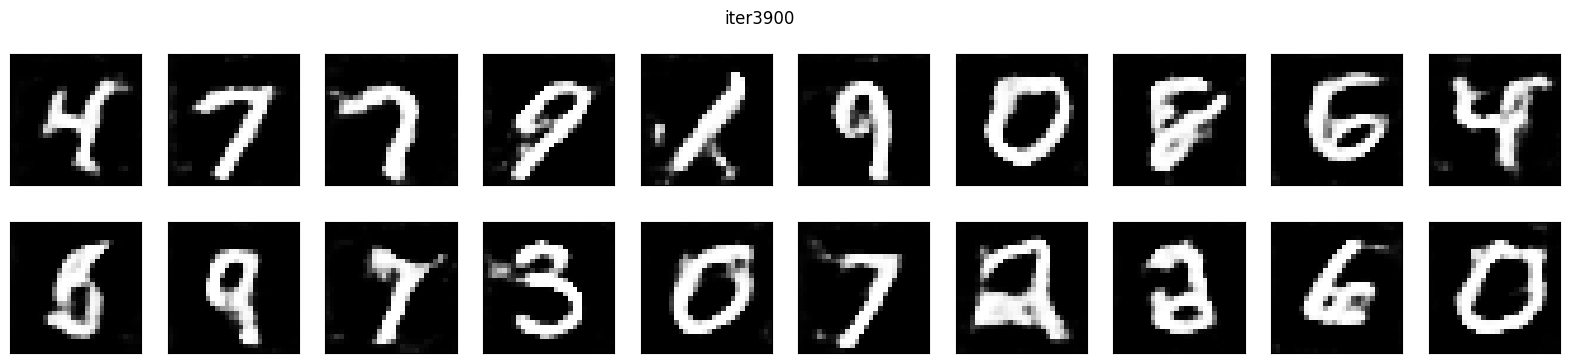

04000 | D loss: 1.2845 | G loss: 0.7175 | D(real): 0.474 | D(fake): 0.475


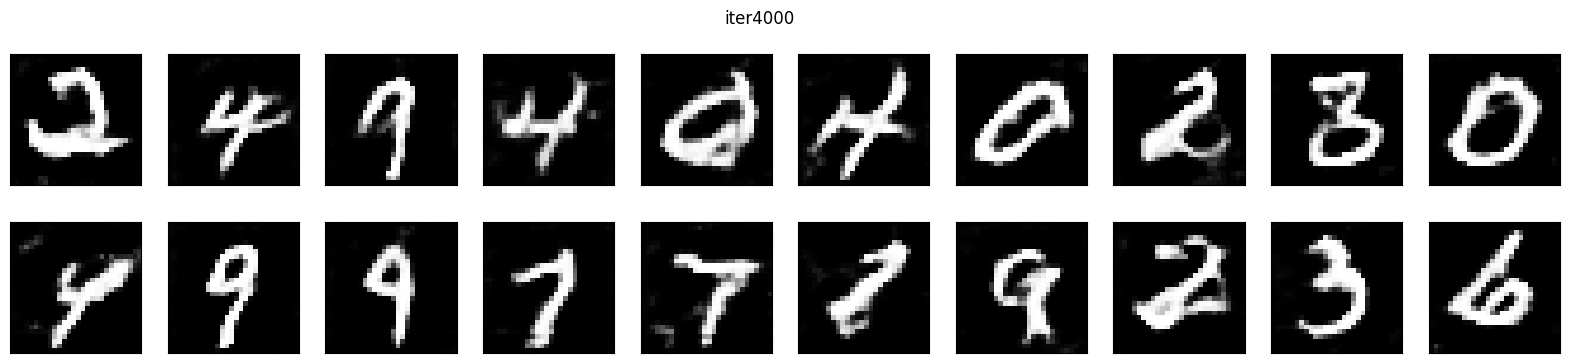

In [121]:
for i in range(iterration+1):
  # Discriminator 학습
  # d_loss, d_real_prob, d_fake_prob=train_discriminator(x_train)
  d_loss, d_real_prob, d_fake_prob=train_discriminator_step3(x_train,y_train)
  # Generator 학습
  g_loss=train_generator_step3()
  # g_loss=train_generator()


  # 100 iteration마다 진행상황 출력 + 이미지 생성
  if(i%100==0):
    # 현재 학습 상태 출력
    print(f"{i:05d} | D loss: {d_loss:.4f} | G loss: {g_loss:.4f} | "
          f"D(real): {d_real_prob:.3f} | D(fake): {d_fake_prob:.3f}")
    # 생성 이미지 시각화
    plt.figure(figsize=(20,4))
    plt.suptitle('iter'+str(i))

    # 20개의 이미지를 생성해서 출력
    for k in range(20):
      plt.subplot(2,10,k+1)
      #step1~2
      # img=generator.predict(np.random.normal(0,1,(1,noise_dimension)))
      #step3
      noise = np.random.normal(0, 1, (1, noise_dimension))
      label = np.array([[np.random.randint(0,10)]], dtype="int32")
      img = generator.predict([noise, label], verbose=0)[0]
      # plt.imshow(img[0].reshape(28,28),cmap='gray')
      plt.imshow(img.squeeze(), cmap='gray')
      plt.xticks([]);plt.yticks([])
    plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 472ms/step


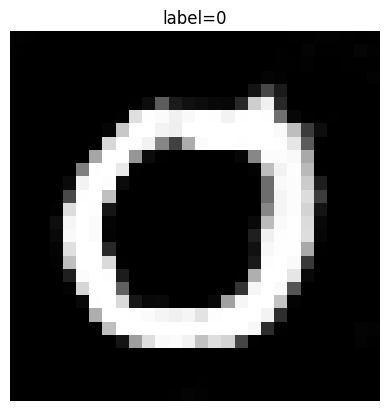

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


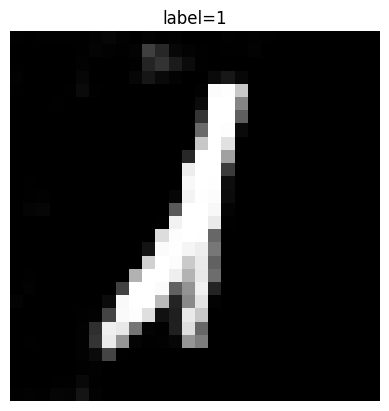

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


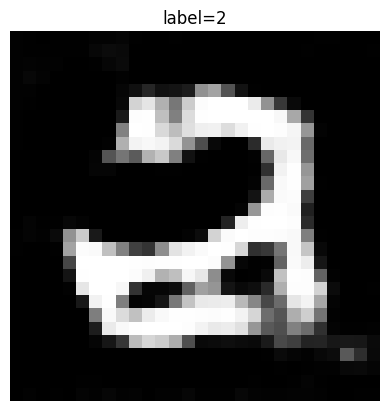

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


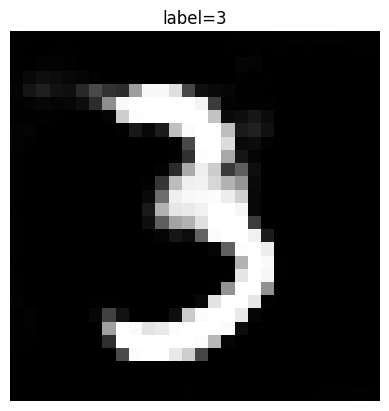

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


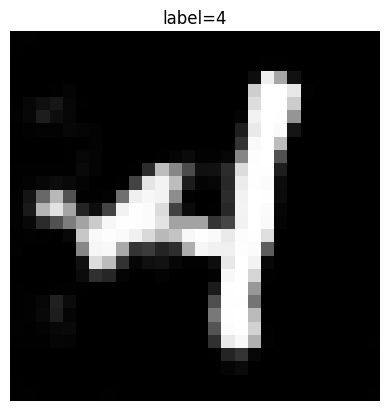

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


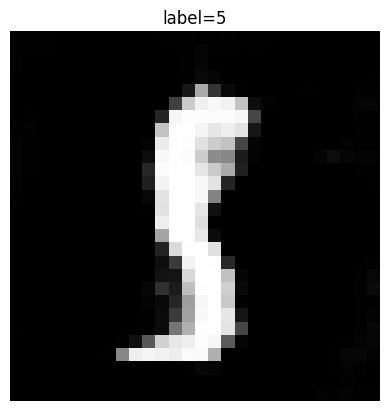

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


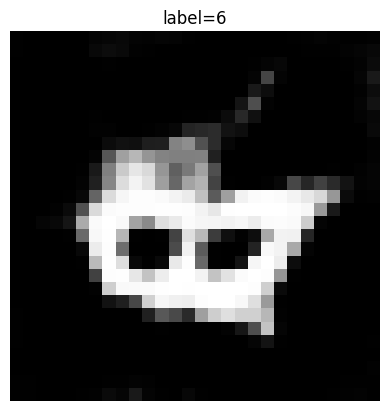

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


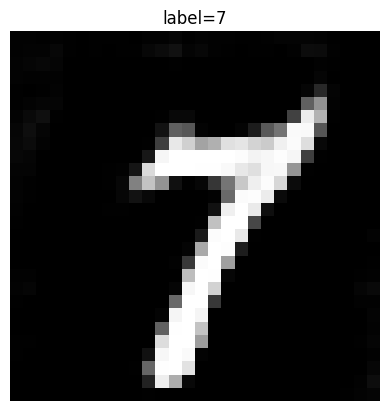

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


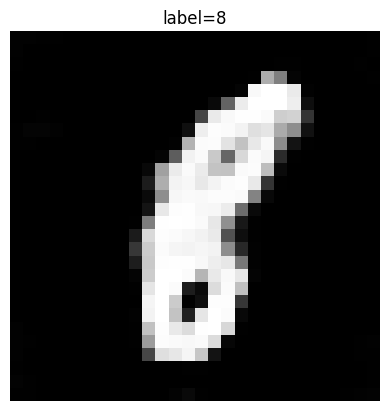

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


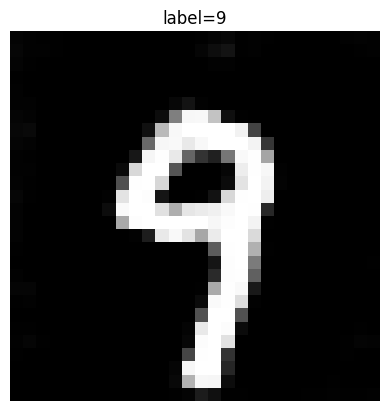

In [122]:
for digit in range(10):
    noise = np.random.normal(0,1,(1,noise_dimension))
    label = np.array([[digit]])
    img = generator.predict([noise, label])[0]
    plt.imshow(img.squeeze(), cmap='gray')
    plt.title(f"label={digit}")
    plt.axis('off')
    plt.show()
